Data files needed by this notebook are attached to the Github releases page: https://github.com/marius311/Planck_FlexKnot/releases

Some initialization:

In [1]:
%pylab inline

from cosmoslik import *
from getdist import MCSamples
import dill as pickle
from scipy.integrate import quad
from scipy.optimize import brentq

def get_τ_posterior(c, k="cosmo.tau_out", ranges=None, smooth=0.1):
    d = MCSamples(samples=c[k], weights=c['weight'], 
                  names=['x'], ranges=({'x':ranges} if ranges else None),
                  settings={'smooth_scale_1D':(smooth or -1)}).get1DDensity(0)
    return lambda τ: d.Prob(τ)[0]

def flatten_τ(c, Pτ, k="cosmo.tau_out", maxweight=10000):
    origweight = c['weight'].sum()
    Z = getattr(c,"Z",None)
    c = c.reweighted(lambda **kw: min(maxweight,1/Pτ(kw[k])))
    c['weight'] *= origweight/c['weight'].sum()
    if Z: c.Z=Z
    return c

Populating the interactive namespace from numpy and matplotlib


\
Load the FlexKnot chains which just sampled the prior with flat priors on the knot amplitudes/positions:

In [2]:
cflex_noclik = {i:load_chain("chains/chain_reioflexknots2_fixclamp_nmodes%i_noclik_gpprior"%i).join() for i in range(1,6)}

\
Compute the induced $\tau_{15}$ prior from this:

In [3]:
Pτ15_flex = {i: get_τ_posterior(c, k="cosmo.tau15_out", ranges=(0,Inf)) for i,c in cflex_noclik.items()}

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


\
Load the FlexKnot results (sampled with polychord):

In [4]:
with open("polychord/reioflexknots2_fixclamp_nmodes1to5_onlylowp_simall_EE_gpprior_pptau15", "rb") as f:
    # apply an unimportant tau15<0.1 prior to thin some very low-weight samples
    cflex_simall = {i: c.sample(c["cosmo.tau15"]<0.1) for i,c in pickle.load(f).items()}

\
Flatten the $\tau_{15}$ prior:

In [5]:
cflex_simall_flatτ = {i: flatten_τ(cflex_simall[i], Pτ15_flex[i], k="cosmo.tau15") for i in range(1,6)}

\
Plot up result given individual number of knots, and the combined result which marginalizes over the number of knots:

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


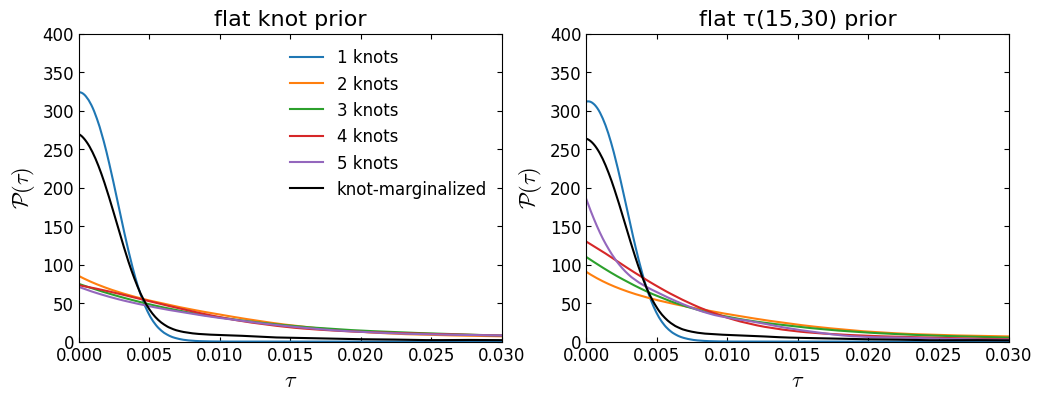

In [6]:
figure(figsize=(12,4))

subplot(121)
for i in range(1,6):
    cflex_simall[i].like1d("cosmo.tau15", c="C%i"%(i-1), ranges=(0,Inf), label="%i knots"%i)
Chains(cflex_simall.values()).join().like1d("cosmo.tau15", ranges=(0,Inf), c="k", label="knot-marginalized")
legend()
xlim(0,0.03)
ylim(0,400)
xlabel(r"$\tau$")
ylabel(r"$\mathcal{P}(\tau)$")
title("flat knot prior")

subplot(122)
for i in range(1,6):
    cflex_simall_flatτ[i].like1d("cosmo.tau15", c="C%i"%(i-1), ranges=(0,Inf), label="%i knots"%i)
Chains(cflex_simall_flatτ.values()).join().like1d("cosmo.tau15", ranges=(0,Inf), c="k", label="knot-marginalized")
xlim(0,0.03)
ylim(0,400)
ylabel(r"$\mathcal{P}(\tau)$")
xlabel(r"$\tau$")
title("flat τ(15,30) prior");

\
Compute the 95% upper bound by doing a KDE fit to  the posterior (with getdist) then integrating to get the CDF, and solving for where this equals 0.95.

In [9]:
bound = 0.95

c = Chains(cflex_simall_flatτ.values()).join()
# c = Chains(cflex_simall.values()).join()

Pτ = get_τ_posterior(c, k="cosmo.tau15", ranges=(0,Inf))
brentq(lambda τ: quad(Pτ, 0, τ, limit=10000)[0] / quad(Pτ, 0, 0.1, limit=10000)[0] - bound, 0, 0.1)

Removed no burn in


0.018491411712674117